# Определение возраста покупателей

# Импортирование нужных библиотек

In [3]:
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

2024-04-16 21:16:47.637283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-16 21:16:47.637319: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Исследовательский анализ данных

**Загрузка данных**

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


**Общая информация**

In [6]:
labels.info()

display(labels.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


**Описание данных**

Столбец 'file_name' - наименование файла
Столбец 'real_age' - настоящий возраст (целевой признак)

**Распаковка данных**

In [7]:
features, target = next(train_gen_flow)

**Вывод размера выборки**

In [8]:
print('Размер выборки = ', features.shape)

Размер выборки =  (32, 224, 224, 3)


**Построение графиков распределения возраста**

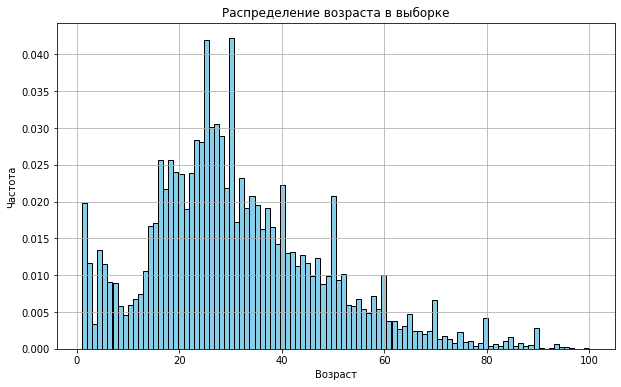

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=100, color='skyblue', edgecolor='black', density=True)  # Использование параметра density для отображения частоты
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

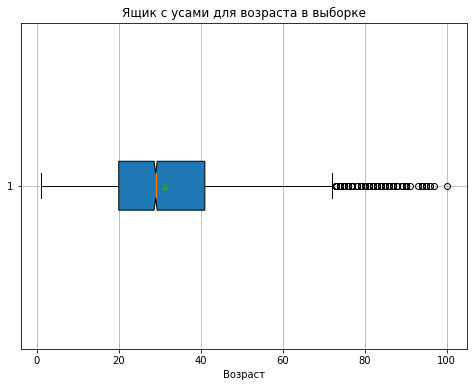

In [10]:
plt.figure(figsize=(8, 6))
plt.boxplot(labels['real_age'], vert=False, patch_artist=True, notch=True, showmeans=True)
plt.title('Ящик с усами для возраста в выборке')
plt.xlabel('Возраст')
plt.grid(True)
plt.show()

**На основе полученных графиков можно сделать несколько выводов:**

1. *Распределение возраста (гистограмма)*:
* Распределение не является нормальным и показывает несколько пиков;
* Основная часть данных сосредоточена в диапазоне от 20 до 40 лет.

2. *Распределение возраста (ящик с усами)*:
* Медиана возраста лежит ближе к началу 30-летнего возраста, что подтверждает, что средний возраст в выборке — около 30 лет.
* Большая часть данных (межквартильный размах) находится в диапазоне примерно от 20 до 40 лет.
* Наличие множества выбросов, особенно в сторону старших возрастных групп, указывает на то, что в выборке присутствуют отдельные примеры с значительно более высоким возрастом, чем у большинства. Это может затруднить обучение модели для точного предсказания возраста в этих старших возрастных группах из-за относительного недостатка данных.

**Вывод на экран 15 фотографий**

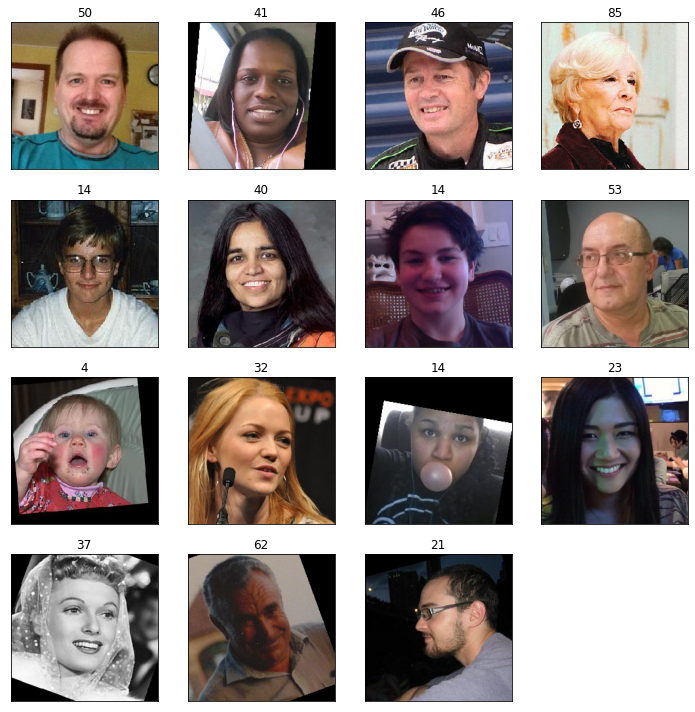

In [11]:
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

**Промежуточный вывод по исследовательскому анализу данных**

1. *Размер выборки и распределение возраста:*
* Распределение возраста в выборке неравномерно, с основным акцентом на возрастной диапазон 20–40 лет. Это указывает на возможную предвзятость модели в пользу этой возрастной категории.
* Но, в то же время разнообразие возрастов в выборке, включая детей и пожилых людей, поможет модели лучше обобщать и точнее предсказывать возраст на изображениях, не представленных в большом количестве в тренировочном датасете.

2. *Качество и разнообразие изображений:*
* Некоторые фотографии кажутся профессиональными, в то время как другие — любительскими, что также способствует разнообразию обучающего набора данных и улучшению обобщающей способности модели.
* Все изображения отцентрированы по горизонтали и вертикали

3. *Влияние на обучение модели:*
* Из-за неравномерного распределения возрастов в датасете, важно использовать методы аугментации данных и техники балансировки классов для уменьшения потенциального смещения модели.
* Может потребоваться регулировка функции потерь, чтобы уменьшить вес редко представленных возрастных групп, увеличив тем самым общую точность модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25, 
        horizontal_flip=True, 
        rescale=1/255
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=1
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=1
    )
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    ) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model
 
def train_model(model, train_data, test_data, 
    batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data, 
        validation_data=test_data,
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model


```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 73s - loss: 182.1079 - mae: 10.2717 - val_loss: 901.9385 - val_mae: 25.1796
Epoch 2/10
356/356 - 56s - loss: 76.1656 - mae: 6.6816 - val_loss: 206.5339 - val_mae: 10.6802
Epoch 3/10
356/356 - 57s - loss: 53.8798 - mae: 5.5976 - val_loss: 117.1152 - val_mae: 8.5160
Epoch 4/10
356/356 - 56s - loss: 45.5877 - mae: 5.1408 - val_loss: 92.2171 - val_mae: 7.4272
Epoch 5/10
356/356 - 56s - loss: 40.4485 - mae: 4.9010 - val_loss: 94.2060 - val_mae: 7.4957
Epoch 6/10
356/356 - 56s - loss: 35.1553 - mae: 4.5606 - val_loss: 105.4829 - val_mae: 7.5812
Epoch 7/10
356/356 - 56s - loss: 34.0536 - mae: 4.4736 - val_loss: 91.6322 - val_mae: 7.5143
Epoch 8/10
356/356 - 55s - loss: 32.0231 - mae: 4.3608 - val_loss: 84.3365 - val_mae: 6.8738
Epoch 9/10
356/356 - 46s - loss: 29.7887 - mae: 4.2027 - val_loss: 86.8988 - val_mae: 6.9697
Epoch 10/10
356/356 - 41s - loss: 27.8016 - mae: 4.0735 - val_loss: 84.9547 - val_mae: 6.9452

Test MAE: 6.9452

```

## Анализ обученной модели

Анализ результатов обучения модели позволяет нам понять, насколько успешно модель способна предсказывать возраст людей по их фотографиям, а также выявить потенциальные проблемы и пути их решения. Рассмотрим ключевые аспекты:

1. **Снижение функции потерь (Loss)**
* Обучающая выборка: Наблюдается последовательное снижение значения функции потерь с 182.1079 в первой эпохе до 27.8016 в десятой. Это говорит о том, что модель успешно адаптируется к обучающим данным, оптимизируя свои веса для предсказания возраста.
* Тестовая выборка: Минимальное значение потерь было достигнуто на восьмой эпохе (84.3365), после чего значения потерь незначительно колебались. Это может указывать на начало переобучения или достижение предела возможностей модели на данных тестовых данных.

2. **Точность модели (MAE)**
* Снижение MAE: Средняя абсолютная ошибка (MAE) снизилась с 10.2717 на первой эпохе до 4.0735 на десятой эпохе для обучающего набора и до 6.9452 на тестовом наборе. Это означает, что в среднем модель ошибается на 4-7 лет при определении возраста по фотографии, что может быть приемлемым.

3. **Выводы и рекомендации:**
* Увеличение данных: Для улучшения обобщающей способности модели может потребоваться увеличение и дополнительное разнообразие обучающего набора данных.
* Аугментация данных: Использование более сложных методов аугментации данных может помочь модели лучше обобщать и уменьшить переобучение.


*Итоговый тестовый MAE в 6.9452 является хорошим результатом.*